In [42]:
import matplotlib.pyplot as plt
import numpy as np
import pyro
from scipy.integrate import quad
import torch

In [43]:
class EinastoRadialDist(torch.distributions.TransformedDistribution,
                        pyro.distributions.torch.TorchDistributionMixin):
    """Distribution for radial coordinate of objects with an Einasto density profile."""
    def __init__(self, r_s, alpha):
        base_distribution = torch.distributions.Gamma(3/alpha, 2/alpha)
        transforms = [torch.distributions.PowerTransform(1/alpha),
                      torch.distributions.AffineTransform(0, r_s)]
        super(EinastoRadialDist, self).__init__(base_distribution, transforms)    


def rho_einasto(r, rho_e, r_s, alpha):
    """Einasto density profile."""
    return rho_e * torch.exp(-2/alpha * ((r / r_s)**alpha - 1))

In [31]:
1 * s

31536000.0

In [44]:
kpc_to_cm = 3.086e21  # 1 kpc in cm
cm_to_kpc = 1 / kpc_to_cm
GeV_to_m_sun = 1 / 1.11543e57
m_sun_to_GeV = GeV_to_m_sun
yr_to_s = 365. * 24 * 60**2
s_to_yr = 1 / yr_to_s

In [56]:
max_dm_density(100., 3e-26, "both")

tensor([2.1423e+17, 8.1307e+09])

In [120]:
# Best-fit Einasto parameters for Milky Way halo. From PPPC.
alpha_mw = torch.tensor(0.17)
r_s_mw = torch.tensor(28.44)  # kpc
rho_e_mw = torch.tensor(0.033) * GeV_to_m_sun / cm_to_kpc**3  # M_sun / kpc^3
# Corresponding probability distributions for coordinates
r_dist = EinastoRadialDist(r_s_mw, alpha_mw)
th_dist = pyro.distributions.Uniform(0, np.pi)
phi_dist = pyro.distributions.Uniform(-np.pi, np.pi)

# Total MW DM mass in M_sun. Cross-checked with PPPC.
m_mw_dm = quad(lambda r: 4*np.pi*r**2*rho_einasto(r, rho_e_mw, r_s_mw, alpha_mw).numpy(),
               0., np.inf, epsabs=0, epsrel=1e-4)[0]

Omega_cdm = torch.tensor(0.2589)  # from Planck 2015
z_eq = torch.tensor(3500.)
z_final = torch.tensor(30.)  # redshift at which to end PBH halo evolution
d_earth = torch.tensor(8.33)  # kpc
age_of_universe = torch.tensor(13e9)  # yr


def max_dm_density(m_dm, sv):
    """
    Parameters
    ----------
    m_dm : float
        Dark matter mass, GeV.
    sv : float
        cm^3 / s.
    units : string
        "astro", "particle" or "both". This controls whether the
        result is given in M_sun/kpc^3, GeV/cm^3 or both.
        
    Returns
    -------
    Maximum DM density in GeV / cm^3.
    """
#     if units == "astro":
#         factor = torch.tensor(GeV_to_m_sun / cm_to_kpc**3)
#     elif units == "particle":
#         factor = torch.tensor(1.)
#     elif units == "both":
#         factor = torch.tensor([GeV_to_m_sun / cm_to_kpc**3, 1.])
    return m_dm / (sv * age_of_universe * yr_to_s)


def pbh_halo_mass(m_pbh):
    """From arxiv:0706.0864. M_sun."""
    return m_pbh * (1 + z_eq) / (1 + z_final)


def truncation_radius(m_halo):
    """From arxiv:0706.0864. kpc."""
    return 58e-3 * m_halo**(1/3)


def ucmh_lum(m_pbh, nu, m_dm, sv):
    """Hz."""
    m_h = pbh_halo_mass(m_pbh)  # M_sun
    r_tr = truncation_radius(m_h)  # kpc
    rho_max = max_dm_density(m_dm, sv)  # GeV / cm^3
    r_p = torch.tensor(7.07566e-8)  # kpc. todo: solve for this!
    
    r_term = (3*r_p**(2*nu)*r_tr**(3-2*nu) - 2*nu*r_p**3)  # kpc^3
    print(2*np.pi * sv * rho_max**2)
    
    return (2*np.pi * sv*cm_to_kpc**3/s_to_yr * rho_max**2 / (m_dm**2 * (9 - 6*nu)) * r_term)


def to_galactic_coords(r, th, phi, deg=True):
    """Converts from spherical coordinates centered on the GC to galactic coordinates."""
    x = r * torch.sin(th) * torch.cos(phi)
    y = r * torch.sin(th) * torch.sin(phi)
    z = r * torch.cos(th)
    
    d = torch.sqrt((x + d_earth)**2 + y**2 + z**2)
    b = np.pi/2 - torch.acos(z / d)
    l = torch.atan2(y, x + d_earth)
    
    if deg:
        return torch.stack([d, 180/np.pi*b, 180/np.pi*l])
    else:
        return torch.stack([d, b, l])


def gen_pbhs(n_samples=1, mass_dist=pyro.distributions.Delta(torch.tensor(1.)), f_pbh=1.):
    """
    Parameters
    ----------
    n_samples : int or torch.Size
        Number of PBHs to generate.
    mass_dist : pyro.distribution.Distribution
        PBH mass probability distribution. Defaults to a delta function at 1 M_sun.
    f_pbh : float
        PBH abundance divided by DM abundance. Defaults to 1.
        
    Returns
    -------
    m_pbh : torch.tensor
        Sampled PBH masses.
    position : torch.tensor
        Sampled positions in galactic coordinates (d, b, l) (kpc, deg, deg).
    sample_scaling : torch.tensor
        Factor required to scale n_samples by so the total of the sampled PBH masses
        matches the amount of MW halo mass the PBHs should comprise. Eg, all histogram
        counts should be rescaled by sample_scaling.
    """
    if type(n_samples) == int:
        n_samples = torch.Size([n_samples])
    m_pbh = mass_dist(n_samples)
    position = torch.stack([r_dist(n_samples), th_dist(n_samples), phi_dist(n_samples)])
    sample_scaling = f_pbh * m_mw_dm / torch.sum(m_pbh)
    return m_pbh, to_galactic_coords(*position), sample_scaling

In [121]:
3e-26*cm_to_kpc**3/s_to_yr

3.219141719397877e-83

In [122]:
ucmh_lum(1., 2.25, 100., 3e-26)

tensor(1.2461e-05)


tensor(0.)

In [83]:
kpc_to_cm**3 * 4.4143e-31

1.297327458072008e+34

In [84]:
print(max_dm_density(100., 3e-26))
print(pbh_halo_mass(1.))
print(truncation_radius(pbh_halo_mass(1.)))

tensor(8.1307e+09)
tensor(112.9355)
tensor(0.2804)


In [6]:
m_pbhs, positions, scalings = gen_pbhs(100000)

(-90, 90)

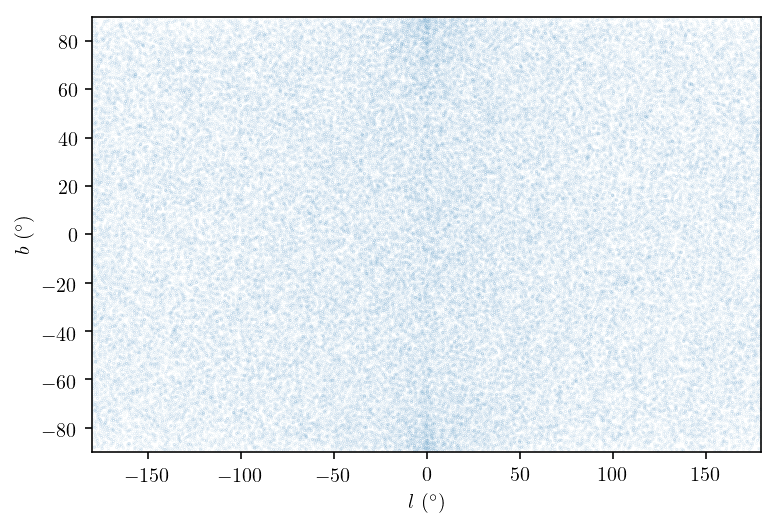

In [7]:
plt.plot(positions[2].numpy(), positions[1].numpy(), '.', markersize=0.05)
plt.xlabel(r"$l~(^\circ)$")
plt.ylabel(r"$b~(^\circ)$")
plt.xlim(-180, 180)
plt.ylim(-90, 90)

Text(0.5, 1.0, 'l')

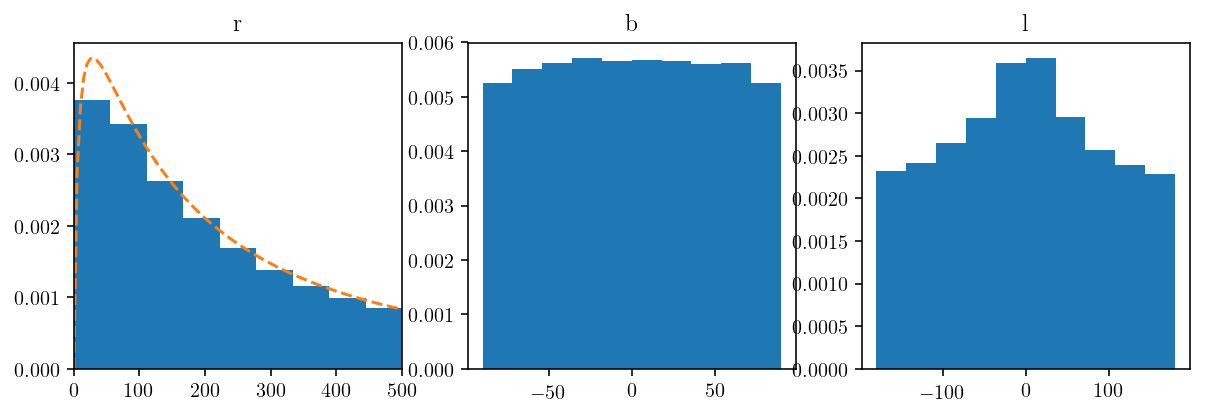

In [8]:
plt.figure(figsize=(10, 3))

plt.subplot(1, 3, 1)
rs = torch.linspace(0, 500)
plt.hist(positions[0].numpy(), density=True, bins=np.linspace(0, 500, 10))
plt.plot(rs.numpy(), (5e-9 * (rs/r_s_mw)**2 * rho_einasto(rs, rho_e_mw, r_s_mw, alpha_mw)).numpy(), '--')
plt.xlim(0, 500)
# plt.ylim(1e-10, 1e-2)
# plt.yscale("log")
plt.title("r")

plt.subplot(1, 3, 2)
plt.hist(positions[1], density=True)
plt.title("b")

plt.subplot(1, 3, 3)
plt.hist(positions[2], density=True)
plt.title("l")